In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_loss_accuracy(history):
    rcParams['figure.figsize'] = 20,3
    fig, ax = plt.subplots(1,2)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].title.set_text('model loss')
    ax.flat[0].set(ylabel = 'loss',xlabel='epoch')
    ax[0].legend(['train', 'val'], loc='upper right')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[0].title.set_text('model accuracy')
    ax.flat[1].set(ylabel = 'accuracy',xlabel='epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()

In [3]:
def load_data(path='../data/'):
    df_sensors = pd.read_csv(path + 'PdM_telemetry.csv')
    df_metadata = pd.read_csv(path + 'PdM_machines.csv')
    df_maintenance = pd.read_csv(path + 'PdM_maint.csv')
    df_failures = pd.read_csv(path + 'PdM_failures.csv')
    df_errors = pd.read_csv(path + 'PdM_errors.csv')
    return df_sensors, df_metadata, df_maintenance, df_failures, df_errors

In [4]:
df_sensors, df_metadata, df_maintenance, df_failures, df_errors = load_data()

In [5]:
# Format date & time. Sort based on date for better readability
tables = [df_sensors, df_maintenance, df_failures, df_errors]
for df in tables:
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df.sort_values(["datetime", "machineID"], inplace=True, ignore_index=True)

In [6]:
base_features = list(df_sensors.drop(['datetime', 'machineID'], axis=1).columns)

In [7]:
machine_id = 10
time_step = 24

In [11]:
df = df_sensors.merge(df_failures, how='left').merge(df_errors, how='left').query('machineID == @machine_id').reset_index(drop=True)
# df = df_sensors.merge(df_failures, how='left').merge(df_errors, how='left').merge(df_metadata, how='left').query('model == "model3"').reset_index(drop=True)
df = df.replace('NaN', np.nan)
df['is_error'] = ~((df['errorID'].isnull()))
# df['is_anomaly'] = ~((df['failure'].isnull()))
#Iterar sobre las filas donde 'anomaly' es 1
df['is_anomaly'] = False
for idx in df[~(df['failure'].isnull())].index:
    # Marcar las 24 filas anteriores como anomalías
    start_idx = max(0, idx - time_step)  # Asegurarse de no salir del rango del DataFrame
    df.loc[start_idx:idx, 'is_anomaly'] = True

In [12]:
def create_sequences(values: list) -> np.array:
    output = []
    for i in range(len(values) - time_step + 1):
        output.append(values[i : (i + time_step)])
    return np.stack(output)

In [13]:
scaler_auto = StandardScaler() 
scaler_auto.fit(df.drop(['machineID', 'datetime','failure', 'errorID','is_anomaly','is_error'], axis=1))


StandardScaler()

In [14]:
def transform_values(dataframe, scaler):
    dataframe = dataframe.reset_index(drop=True)
    np_scaled = scaler_auto.transform(dataframe.drop(['machineID', 'datetime','failure', 'errorID','is_anomaly','is_error'], axis=1))
    # np_scaled = np.hstack((np_scaled, dataframe['model'].to_numpy().reshape((dataframe['model'].shape[0]),1)))
    data = create_sequences(np_scaled)
    labels = dataframe.loc[time_step-1:,'is_anomaly'].astype('int').values
    return data, labels

In [15]:
data_list = []
labels_list = []
for key,data_group in df.groupby('machineID', group_keys=False):
    data, labels = transform_values(data_group, scaler=scaler_auto)
    data_list.append(data)
    labels_list.append(labels)
data = np.concatenate(data_list)
labels = np.concatenate(labels_list)

In [16]:
print(data.shape)
print(labels.shape)

(8742, 24, 4)
(8742,)


In [17]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 21)

In [18]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Normal data
# n_train_data = train_data[~train_labels]
# n_test_data = test_data[~test_labels]

# #Abnormal data
# an_train_data = train_data[train_labels]
# an_test_data = test_data[test_labels]

In [33]:
class detector(Model):
  def __init__(self):
    super(detector, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        layers.LSTM(128, activation='relu', return_sequences=True),
                                        layers.LSTM(64, activation='relu', return_sequences=False),
                                        # layers.LSTM(32, activation='relu', return_sequences=True),
                                        # layers.LSTM(8, activation='relu', return_sequences=False),
                                        layers.Dropout(rate=0.2),
                                        layers.RepeatVector(data.shape[1])
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.LSTM(64, activation='relu', return_sequences=True),
                                        layers.LSTM(128, activation='relu', return_sequences=True),
                                        # layers.LSTM(32, activation='relu', return_sequences=True),
                                        # layers.LSTM(64, activation='relu', return_sequences=True),
                                        layers.Dropout(rate=0.2),
                                        layers.TimeDistributed(layers.Dense(data.shape[2])),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
#Compiling Model
autoencoder = detector()
autoencoder.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
history = autoencoder.fit(train_data, train_data, epochs = 500, batch_size=512, validation_data=(test_data, test_data), callbacks=[callback])
# autoencoder.fit(n_train_data, n_train_data, epochs = 150, batch_size=512, validation_data=(n_test_data, n_test_data))

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.3075 - loss: 0.9936 - val_accuracy: 0.3249 - val_loss: 0.9303
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.3333 - loss: 0.9249 - val_accuracy: 0.3495 - val_loss: 0.8973
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.3497 - loss: 0.9011 - val_accuracy: 0.3553 - val_loss: 0.8883
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.3540 - loss: 0.8922 - val_accuracy: 0.3576 - val_loss: 0.8836
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.3583 - loss: 0.8857 - val_accuracy: 0.3617 - val_loss: 0.8803
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.3608 - loss: 0.8861 - val_accuracy: 0.3627 - val_loss: 0.8834
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.3611 - loss: 0.8874 - val_accuracy: 0.3662 - val_loss: 0.8752
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.3662 - loss: 0.8800 - val_accu

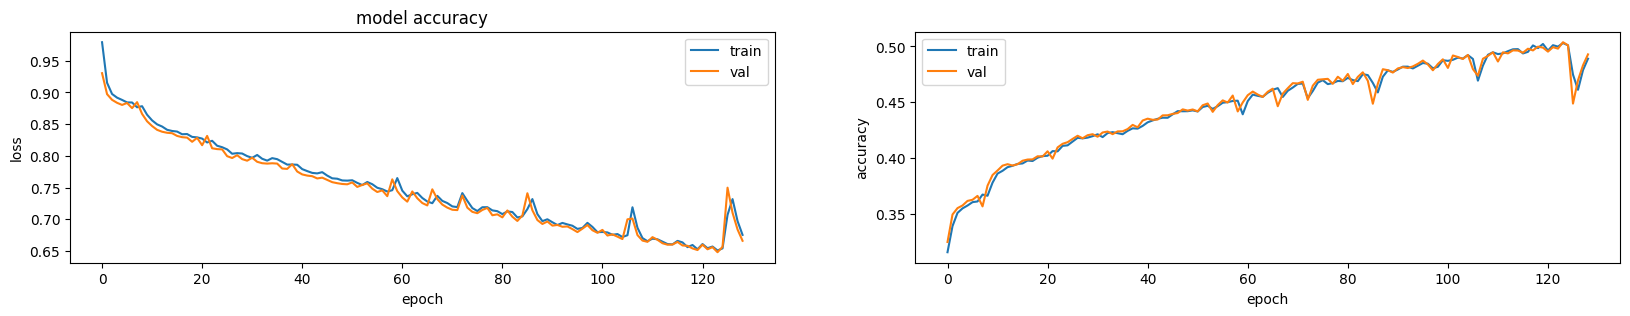

In [35]:
plot_loss_accuracy(history)

In [36]:
# reconstructed = autoencoder(n_train_data)
# train_loss = losses.mae(reconstructed, n_train_data)
# # t = np.mean(train_loss) + np.std(train_loss)
# t = np.mean(train_loss) + (5 * np.std(train_loss))
# print(t)

In [37]:
def result_autoencoder(model: object, x_train: np.array) -> tf.Tensor:
    # Calculate the reconstruction error for each data point
    reconstructions_deep = model.predict(x_train)
    mse = tf.reduce_mean(tf.square(x_train - reconstructions_deep), axis=[1, 2])
    return mse

In [38]:
mse = result_autoencoder(autoencoder, data)
anomaly_deep_scores = pd.Series(mse.numpy(), name="anomaly_scores")

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [39]:
threshold = anomaly_deep_scores.quantile(0.985)

In [40]:
# anomalous_deep = anomaly_deep_scores > threshold

In [41]:
df.loc[time_step-1:,'anomaly_score'] = anomaly_deep_scores.to_numpy()

In [42]:
df['pred_anomaly'] = False
df.loc[df['anomaly_score'] > threshold,'pred_anomaly'] = True

In [43]:
import seaborn as sns
from matplotlib import rcParams

In [48]:
def plot_values(df, base_features):
    rcParams['figure.figsize'] = 20,3
    # for feature in base_features:
    feature='vibration'
    sns.lineplot(df, x='datetime', y=feature)
    sns.scatterplot(df[df['pred_anomaly'] == True], x='datetime', y=feature, color='red', label='Prediction', zorder=7)
    # for error_date in df.loc[df['pred_anomaly'] == True, 'datetime']:
    #     plt.axvline(x=error_date, color='orange', linestyle='--', linewidth=1, label='Error')
    for error_date in df.loc[df['is_anomaly'] == True, 'datetime']:
        plt.axvline(x=error_date, color='red', linestyle='--', linewidth=1, label='Error', alpha=0.05)
    for error_date in df.loc[df['is_error'] == True, 'datetime']:
        plt.axvline(x=error_date, color='orange', linestyle='--', linewidth=1, label='Possible Error', alpha=0.5)
    plt.show()


ID: 10


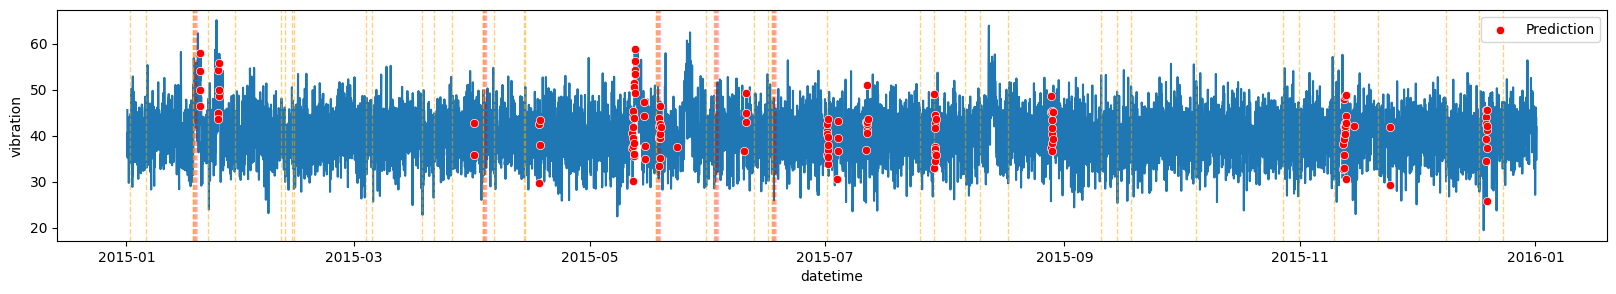

In [49]:
machine_id = np.random.choice(df.machineID.unique())
# machine_id = 10
print('ID:',machine_id)
df_tmp = df.query('machineID == @machine_id')
plot_values(df_tmp, base_features=base_features)

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


accuracy = accuracy_score(df['is_anomaly'], df['pred_anomaly'])
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(df['is_anomaly'], df['pred_anomaly'])
print(f'Precision: {precision:.2f}')
f1 = f1_score(df['is_anomaly'], df['pred_anomaly'])
print(f'F1 Score (Balance between false positives and true positives): {f1:.2f}')

recall = recall_score(df['is_anomaly'], df['pred_anomaly'])
print(f'Recall (How well anomalies are detected - True positives): {recall:.2f}')

Accuracy: 0.97
Precision: 0.06
F1 Score (Balance between false positives and true positives): 0.06
Recall (How well anomalies are detected - True positives): 0.06
